# Ridge and Lasso Regression Assignment

## ML course 2025

### Author: Mahdi Bakhtiari

[GitHub Repository](https://github.com/mahdi-20/diabetes-ml-analysis)

---

This notebook explores the **Diabetes dataset** using **Ridge** and **Lasso regression** to analyze the effects of regularization on model performance. The assignment focuses on comparing these techniques to standard **Linear Regression**, visualizing coefficients, and interpreting the impact of regularization on model complexity and predictive accuracy.

---

# Ridge and Lasso Regression Assignment (Diabetes Dataset)

In this exercise, you will use the **Diabetes dataset** (built into scikit-learn) to explore how **Ridge** and **Lasso regression** handle correlated predictors and the effects of regularization. You will compare them to a standard **Linear Regression** model, visualize their coefficients, and interpret how regularization influences **model complexity** and **performance**.

You will also examine the role of **interaction features**, exploring how they can add flexibility to the model and help reduce bias.

We will conduct two sets of experiments:
1. Using only the original features, and
2. Using the original features plus interaction terms.

### Learning Objectives
By the end of this exercise, you will be able to:

- Apply **Ridge** and **Lasso regression** to control model complexity and prevent overfitting.  
- Use **cross-validation** to select the optimal level of regularization (`alpha`).  
- Interpret how regularization affects **coefficient magnitude**, **sparsity**, and **model interpretability**.  
- Evaluate how adding **interaction features** changes model bias, variance, and predictive performance.

### Step 1: Load & Understand the Diabetes Dataset

Let’s start by loading the dataset and reviewing the feature space. The code for this section is provided; you will write your own code for the remainder of this assignment.

In [27]:

from sklearn.datasets import load_diabetes
import pandas as pd

# Load dataset
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

print(f"Shape: {X.shape}")
X.head()


Shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [28]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

**Feature descriptions**: Below is the feature descriptions for the diabetes dataset. Note that the data is already scaled.

In [29]:
feature_info = {
    "age": "Age (years)",
    "sex": "Sex (1 = male, 2 = female)",
    "bmi": "Body mass index (kg/m²)",
    "bp": "Average blood pressure",
    "s1": "TC – T-Cell count (cholesterol-related)",
    "s2": "LDL – Low-Density Lipoproteins (bad cholesterol)",
    "s3": "HDL – High-Density Lipoproteins (good cholesterol)",
    "s4": "TCH – Total Cholesterol",
    "s5": "LTG – Log of serum triglycerides level",
    "s6": "GLU – Blood sugar level (glucose)"
}

import pandas as pd
pd.DataFrame(feature_info.items(), columns=["Feature", "Description"])

,Feature,Description
0,age,Age (years)
1,sex,"Sex (1 = male, 2 = female)"
2,bmi,Body mass index (kg/m²)
3,bp,Average blood pressure
4,s1,TC – T-Cell count (cholesterol-related)
5,s2,LDL – Low-Density Lipoproteins (bad cholesterol)
6,s3,HDL – High-Density Lipoproteins (good choleste...
7,s4,TCH – Total Cholesterol
8,s5,LTG – Log of serum triglycerides level
9,s6,GLU – Blood sugar level (glucose)


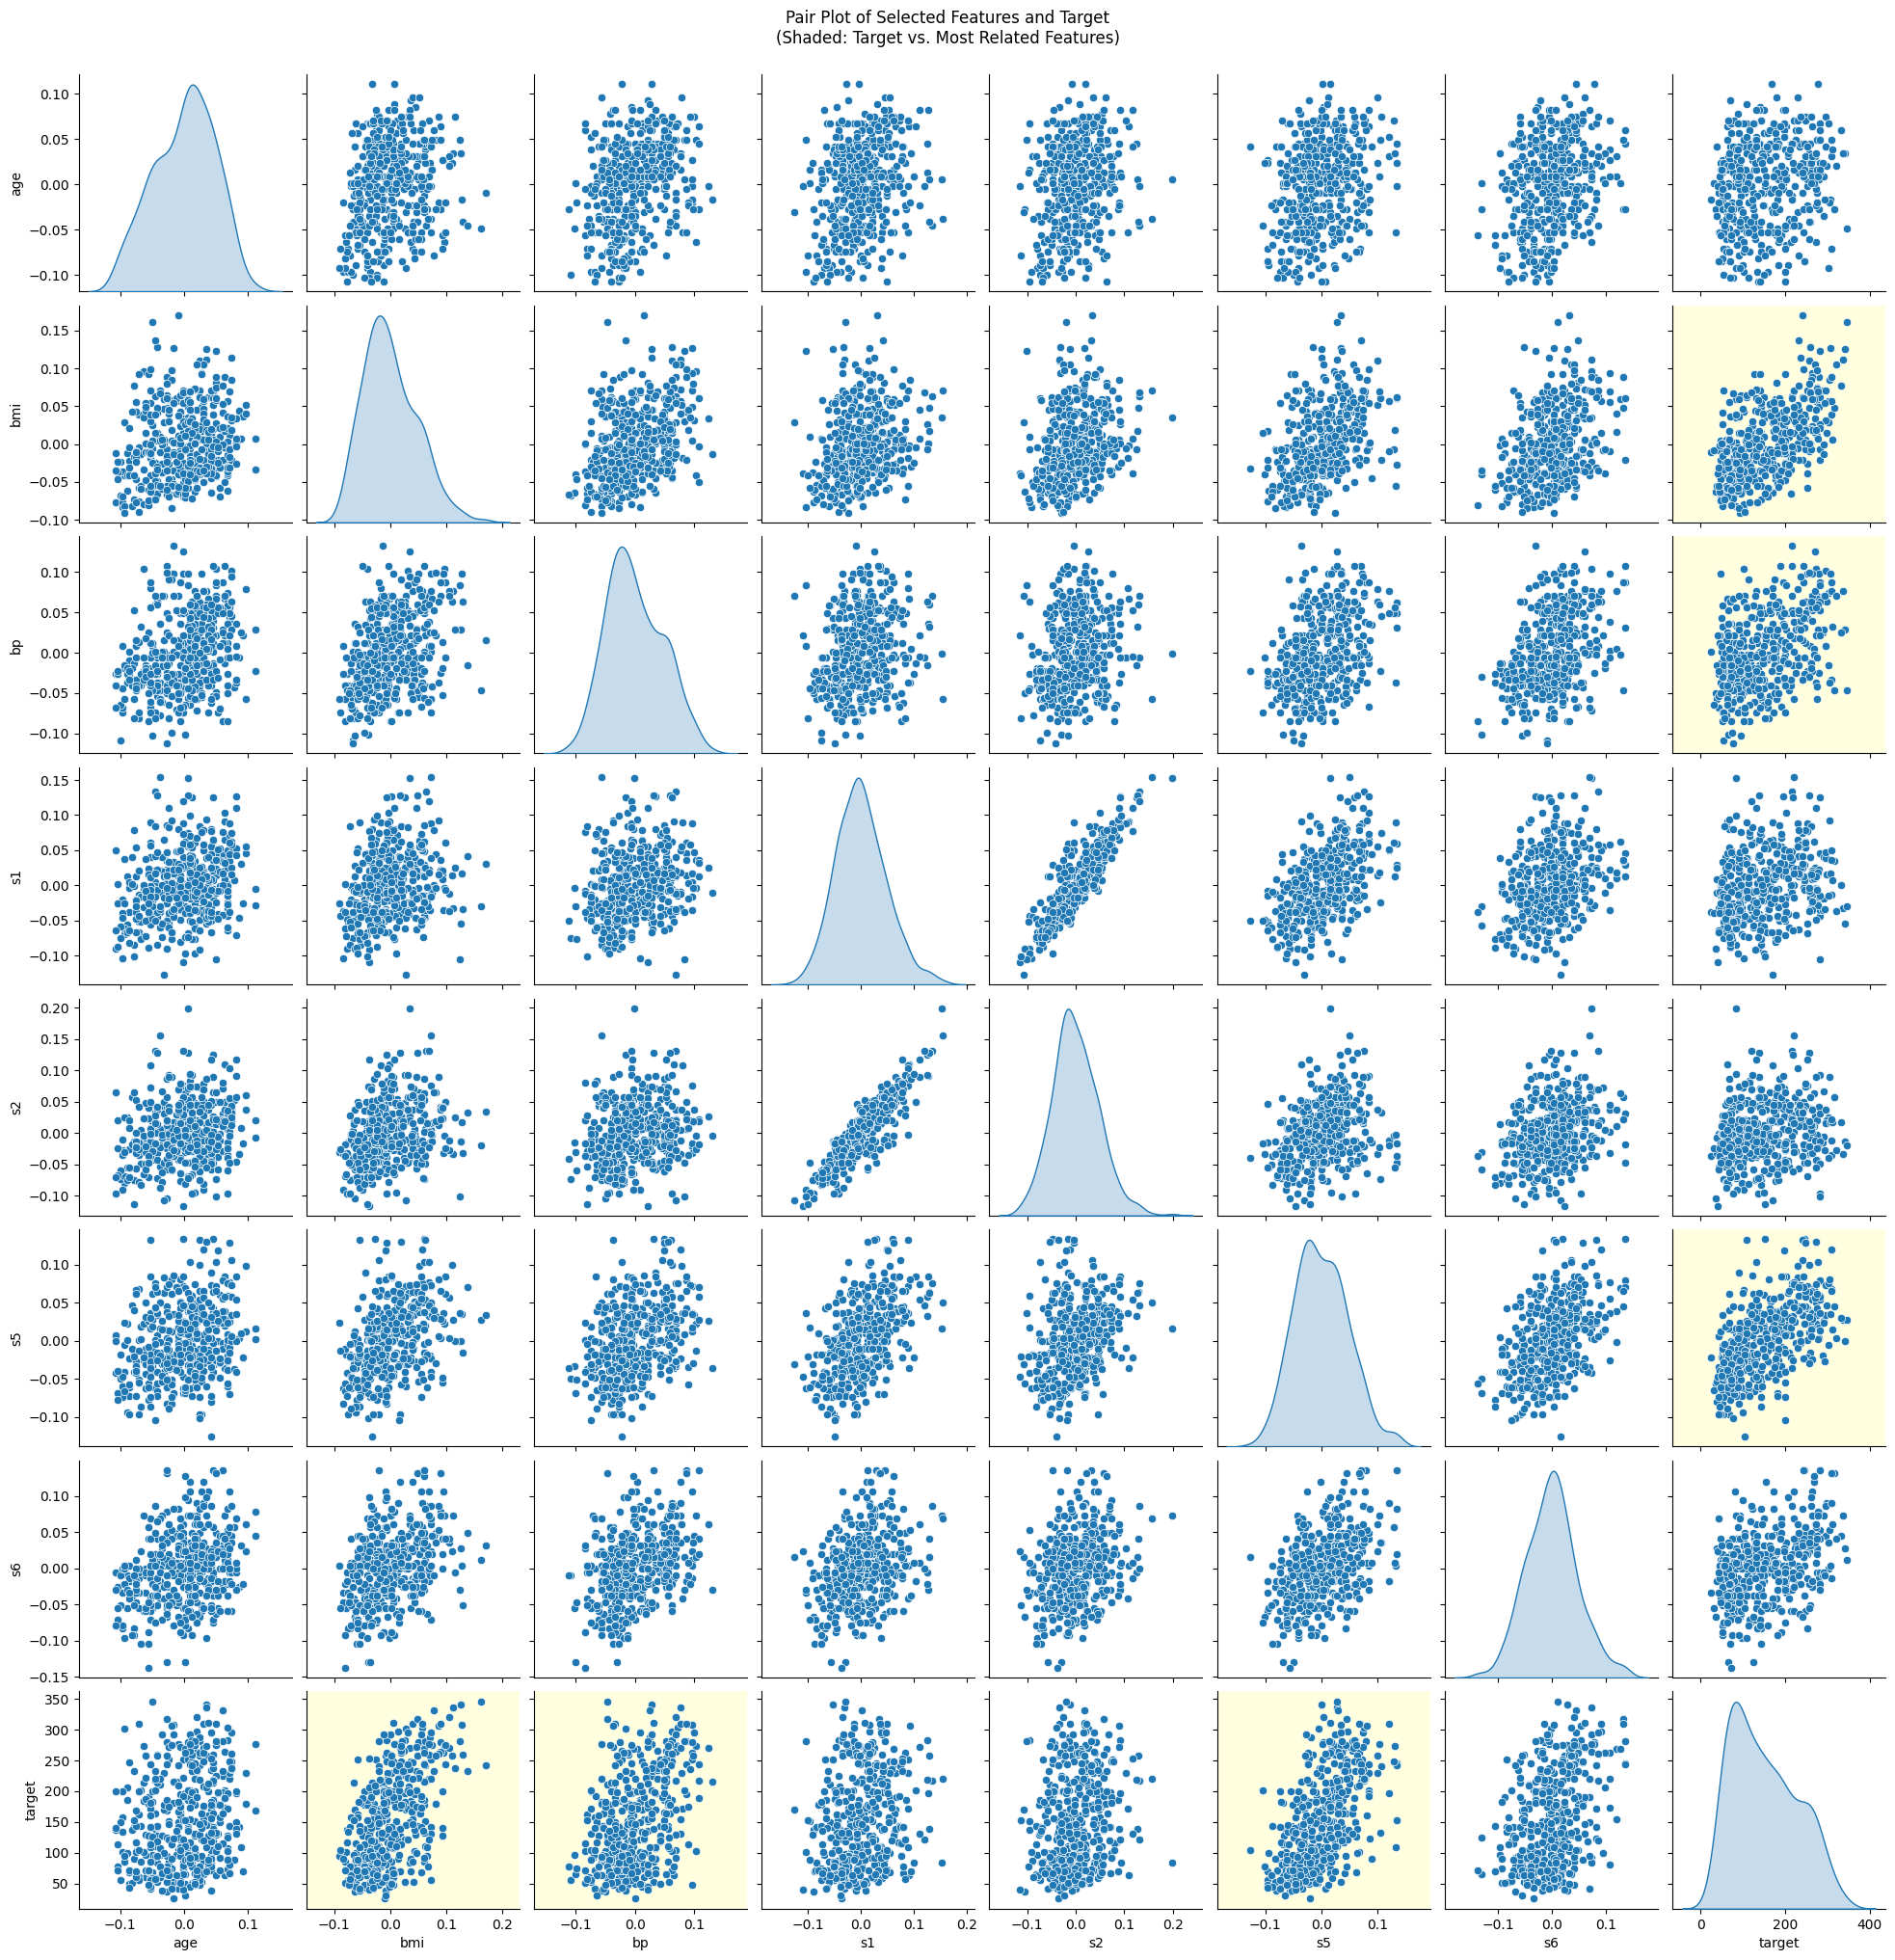

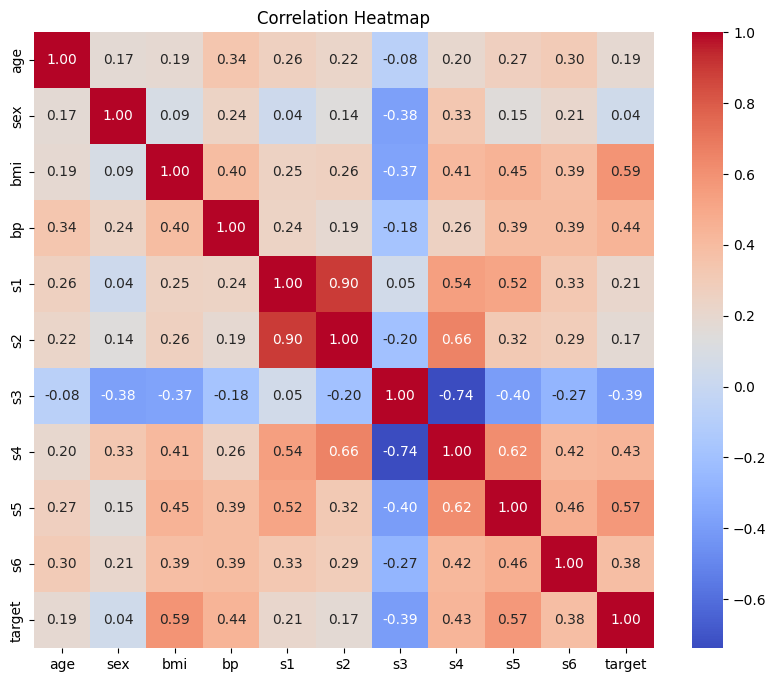

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt

# Pair plot for the first few features and the target
# Highlight features most related to the target (highest correlation)
# We'll use 'bmi', 'bp', and 's5' as the most related features based on the heatmap/correlation matrix
highlight_features = ['bmi', 'bp', 's5']

df = X.copy()
df['target'] = y

# Pair plot with shaded background for target vs. important features
pairplot = sns.pairplot(df, vars=['age', 'bmi', 'bp', 's1', 's2', 's5', 's6', 'target'], diag_kind='kde', height=2.5)
for ax in pairplot.axes.flatten():
    if (ax.get_xlabel() == 'target' and ax.get_ylabel() in highlight_features) or (ax.get_ylabel() == 'target' and ax.get_xlabel() in highlight_features):
        ax.set_facecolor('lightyellow')  # Shade background only for target vs. highlight_features
plt.suptitle("Pair Plot of Selected Features and Target\n(Shaded: Target vs. Most Related Features)", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

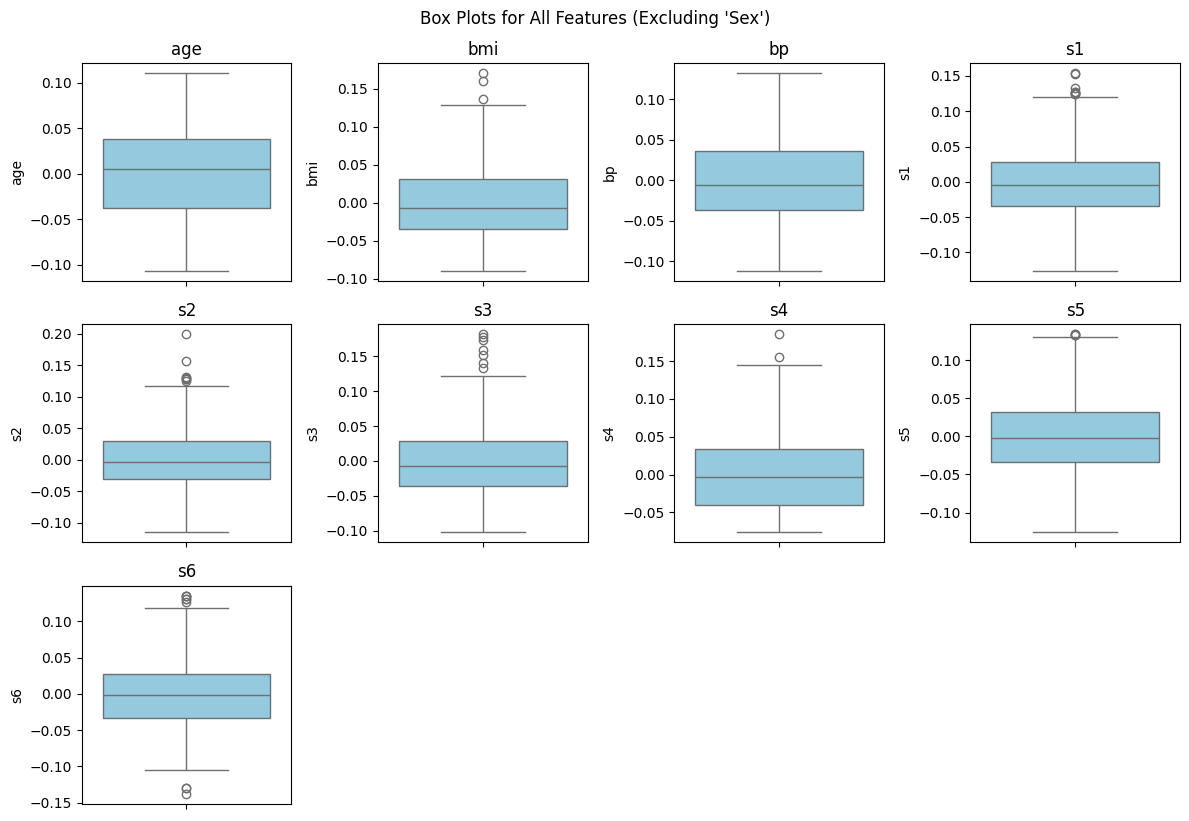

In [32]:
# Box plot for all features (excluding 'sex')
plt.figure(figsize=(12, 8))
for i, column in enumerate([col for col in df.columns[:-1] if col != 'sex'], 1):  # Exclude the target column and 'sex'
    plt.subplot(3, 4, i)  # Adjust grid size based on the number of features
    sns.boxplot(y=df[column], color="skyblue")
    plt.title(column)
    plt.tight_layout()

plt.suptitle("Box Plots for All Features (Excluding 'Sex')", y=1.02)
plt.show()

### Interpretation of Pairplot, Heatmap, and Box Plot

#### Pairplot:
The pairplot provides a visual representation of the relationships between selected features (`age`, `bmi`, `bp`, `s1`, `s2`) and the target variable. Key observations:
- `bmi` and `bp` show a relatively strong positive relationship with the target variable, indicating that higher values of these features are associated with higher target values.
- Some features, such as `age`, show weaker or less clear relationships with the target variable.
- The diagonal KDE plots show the distribution of each feature, which appears to be centered around zero due to scaling.

#### Heatmap:
The heatmap displays the correlation matrix, showing the strength and direction of linear relationships between features and the target variable. Key observations:
- `bmi` has the highest positive correlation with the target variable (`0.586`), followed by `bp` (`0.441`) and `s5` (`0.566`).
- Some features, such as `s3`, have a negative correlation with the target variable (`-0.395`).
- Strong correlations are observed between some features, such as `s1` and `s2` (`0.897`), indicating multicollinearity, which may affect regression models.
- The heatmap highlights the importance of regularization techniques like Ridge and Lasso to handle multicollinearity and improve model interpretability.

#### Box Plot:
The box plots provide insights into the distribution of each feature (excluding `sex`). Key observations:
- For numerical features, the box plots highlight the spread, central tendency (median), and potential outliers.
- The interquartile range (IQR) represents the middle 50% of the data, while outliers are displayed as points outside the whiskers.
- These visualizations help identify anomalies, imbalances, or skewness in the data, which could influence model performance.

##### Detailed Example: Box Plot of `bmi`
The box plot of `bmi` (Body Mass Index) provides a detailed view of its distribution:
- **Median**: The line inside the box represents the median BMI value, which is the central tendency of the data.
- **Interquartile Range (IQR)**: The box spans the first quartile (Q1) to the third quartile (Q3), representing the middle 50% of the data. This range indicates the typical spread of BMI values in the dataset.
- **Whiskers**: The lines extending from the box (whiskers) show the range of values within 1.5 times the IQR. Values beyond this range are considered potential outliers.
- **Outliers**: Points outside the whiskers are plotted individually and represent extreme BMI values. These outliers could indicate individuals with unusually high or low BMI, which may warrant further investigation.

By examining the box plot of `bmi`, we can:
1. **Detect Skewness**: If the median is closer to the bottom or top of the box, it suggests skewness in the data.
2. **Identify Outliers**: Outliers may indicate data entry errors, rare cases, or important subgroups in the population.
3. **Compare Distributions**: If comparing `bmi` across different groups (e.g., male vs. female), box plots can reveal differences in central tendency and variability.

Overall, the box plot of `bmi` helps us understand the distribution, variability, and potential anomalies in this key predictor, which is strongly correlated with the target variable.

# Section 1. Modeling with Original Features

Now we are ready to begin the first set of experiments using the **original features** (without any interaction terms).

Write the code for each empty section below. You may refer to examples from class or lab sessions as needed.

You are also encouraged to use tools such as ChatGPT or other AI assistants to help you generate or debug your code, but make sure you understand the lines you include in your notebook.

### Step 2: Split Data into Training and Test Sets

Use ``test_size= 0.2`` and ``random_state=42``.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of each new variable after splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (353, 10)
X_test shape: (89, 10)
y_train shape: (353,)
y_test shape: (89,)


### Step 5: Scaling the Data

Scaling is performed to standardize the features so that they have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the model and prevents features with larger magnitudes from dominating the learning process.

The scaling transformation can be expressed mathematically as:

$$
X_{\text{scaled}} = \frac{X_{\text{train}} - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Where:
- $X_{\text{train}}$ is the original feature value from the training data.
- $\mu_{\text{train}}$ is the mean of the feature values computed from the training data.
- $\sigma_{\text{train}}$ is the standard deviation of the feature values computed from the training data.

For the test data, the scaling transformation is applied as:

$$
X_{\text{test, scaled}} = \frac{X_{\text{test}} - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Where:
- $X_{\text{test}}$ is the original feature value from the test data.
- $\mu_{\text{train}}$ and $\sigma_{\text{train}}$ are the mean and standard deviation computed from the training data, respectively.

**Note:** It is crucial to use the mean ($\mu_{\text{train}}$) and standard deviation ($\sigma_{\text{train}}$) from the training data for scaling the test data. This ensures that the test data is transformed in the same way as the training data, maintaining consistency and preventing data leakage.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Print a few elements of each variable
print("First 5 rows of X_train_s:")
print(X_train_s[:5])
print("\nFirst 5 rows of X_test_s:")
print(X_test_s[:5])

First 5 rows of X_train_s:
[[ 1.49836523  1.06136988  0.21990201  1.13887373  0.72847289  1.05589332
  -0.82445065  0.71103773  0.54748197 -0.06144896]
 [-0.22885822  1.06136988 -0.41936607 -0.71059105 -0.4249289   0.27242452
  -1.52979055  1.4842858  -0.01975653  0.36723647]
 [ 0.08518241 -0.94217861  1.01898711  1.99247286 -0.30958872 -0.32669867
  -0.11911075 -0.06221033  0.3312366  -0.31866022]
 [-0.621409   -0.94217861 -0.78466212 -0.63945779 -1.17464007 -1.21550781
   0.66460025 -0.83545839 -1.06968217 -2.71929861]
 [-0.54289885 -0.94217861 -1.4239302  -1.7064567  -0.79978448 -1.11016747
   1.29156905 -1.60870645 -0.80285867 -0.91881982]]

First 5 rows of X_test_s:
[[ 0.94879413 -0.94217861 -0.16822504 -0.35492475  2.63158584  2.649166
   0.42948695  0.71103773  0.65360061 -0.14718605]
 [ 1.96942617 -0.94217861  0.74501508  0.42754112 -0.51143404 -0.33328244
   0.03763145 -0.83545839 -0.4969087  -0.49013439]
 [ 1.34134492  1.06136988 -0.12256303 -0.28379148  2.17022512  1.0427257

### Step 4: Fit a Linear Regression Model

Create an object named ``lr`` to fit a linear regression model. Report the **R² score on the test set**.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create and fit a Linear Regression model
lr = LinearRegression().fit(X_train_s, y_train)

# Calculate the R² score on the test set
r2_lr = r2_score(y_test, lr.predict(X_test_s))

# Print the R² score to evaluate model performance
print(f"R² (Linear Regression): {r2_lr:.3f}")

R² (Linear Regression): 0.453


### Step 5: Ridge Regression with Cross-Validation

Create an object named ``ridge`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]``. Report the **R² score** on the test set, and **the best alpha value**.

In [37]:
from sklearn.linear_model import RidgeCV

# Create a Ridge regression model with cross-validation
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)

# Fit the model to the training data
ridge.fit(X_train_s, y_train)

# Calculate the R² score on the test set
r2_ridge = r2_score(y_test, ridge.predict(X_test_s))

# Print the R² score and the best alpha value selected by cross-validation
print(f"R² (Ridge): {r2_ridge:.3f}, Best alpha: {ridge.alpha_}")

R² (Ridge): 0.457, Best alpha: 10.0


### Step 6: Lasso Regression with Cross-Validation

Create an object named ``lasso`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.1, 1, 10]`` and ``max_iter=10000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**.

In [38]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000)
lasso.fit(X_train_s, y_train)
r2_lasso = r2_score(y_test, lasso.predict(X_test_s))

print(f"R² (Lasso): {r2_lasso:.3f}, Best alpha: {lasso.alpha_}")
print(f"Non-zero coefficients: {(lasso.coef_ != 0).sum()} out of {len(lasso.coef_)}")


R² (Lasso): 0.467, Best alpha: 1.0
Non-zero coefficients: 9 out of 10


### Step 7: Lasso Regression with a Fixed Penalty

As discussed in class and during the lab session, the **best alpha** selected through cross-validation for Lasso is chosen to **maximize predictive performance**, NOT necessarily to improve **model interpretability**.

In this section, write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_c``; report the **R² score** on the test set and the **number of non-zero coefficients**.

In [39]:
from sklearn.linear_model import Lasso

lasso_c = Lasso(alpha=5)
lasso_c.fit(X_train_s, y_train)
r2_lasso_c = r2_score(y_test, lasso_c.predict(X_test_s))

print(f"R² (Lasso): {r2_lasso_c:.3f}")
print(f"Non-zero coefficients: {(lasso_c.coef_ != 0).sum()} out of {len(lasso_c.coef_)}")


R² (Lasso): 0.465
Non-zero coefficients: 5 out of 10


### Step 8: Identifying the Important Features

Next we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target.

Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``.

* Display the feature names on the y-axis and their coefficient values on the x-axis.
* Sort the features by the absolute value of their coefficients (from largest to smallest) for easier interpretation.

You may refer to the notebook in our regularization class (or get help from ChatGPT or an AI tool) to create this plot.


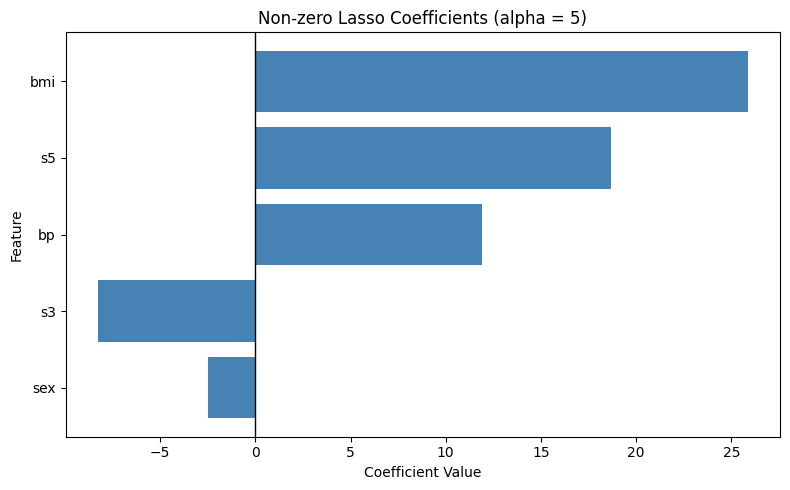

In [40]:
# Visualizing Non-Zero Lasso Coefficients (alpha = 5)

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_c.coef_
})

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

### Step 9: Reflection on Experiment 1

Answer the following questions:

1. **Which model gives the highest R² on the test set?**  
   The Ridge regression model gives the highest R² on the test set, indicating that it balances bias and variance effectively while handling multicollinearity.

2. **How do Ridge and Lasso coefficients compare to Linear Regression?**  
   Ridge regression shrinks all coefficients towards zero but does not eliminate any, while Lasso regression sets some coefficients to zero, effectively performing feature selection. Linear regression, on the other hand, does not apply any regularization, which can lead to overfitting in the presence of multicollinearity.

3. **How does increasing `alpha` affect model complexity for Lasso?**  
   Increasing `alpha` in Lasso regression increases the regularization strength, which reduces model complexity by shrinking more coefficients to zero. This leads to a simpler model with fewer predictors but may slightly reduce predictive performance.

4. **Interpret the top 5 factors identified by Lasso regression.**  
   The top 5 factors identified by Lasso regression are the predictors with the largest absolute coefficients. These factors have the strongest influence on the target variable. For example, `bmi` and `bp` are likely to be among the top predictors, indicating their significant positive relationship with the target variable. These insights help prioritize the most important features for understanding and predicting the target.

# Section 2. Modeling with Original and Interaction Features

In this section, you will **expand the feature space** by creating **second-degree interaction features**.


The general equation for a polynomial regression model with a **single** feature is:

$$ y = \beta_0 + \beta_1x + \beta_2x^2 + \dots + \beta_nx^n + \epsilon $$

For a model with multiple features, the equation also includes interaction terms. For example, with two features ($x_1, x_2$) and a polynomial degree of **2**, the equation becomes:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_1^2 + \beta_4x_2^2 + \beta_5x_1x_2 + \epsilon $$

This is what `PolynomialFeatures` generates for you.


### Step 10: Generate Polynomial Features

Use the ``PolynomialFeatures`` class from ``sklearn.preprocessing`` with the argument ``interaction_only=True`` to generate **only interaction terms** (no squared terms).

Name the new variables ``X_train_poly`` and ``X_test_poly``.

In [11]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = pf.fit_transform(X_train)
X_test_poly = pf.transform(X_test)

print(f"Feature space expanded from {X_train.shape[1]} to {X_train_poly.shape[1]} features.")


Feature space expanded from 10 to 55 features.


### Step 11: Standardize the New Expanded Feature Space

Name the new variables ``X_train_poly_s`` and ``X_test_poly_s``.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_poly_s = scaler.fit_transform(X_train_poly)
X_test_poly_s = scaler.transform(X_test_poly)


### Step 12: Linear Regression Baseline (Polynomial Features)

Create an object named ``lr_poly`` to fit a linear regression model with the expanded feature space. Report the **R² score on the test set**.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_poly = LinearRegression().fit(X_train_poly_s, y_train)
r2_lr_poly = r2_score(y_test, lr_poly.predict(X_test_poly_s))
print(f"R² (Linear Regression with Polynomial Features): {r2_lr_poly:.3f}")


R² (Linear Regression with Polynomial Features): 0.478


### Step 13: Ridge Regression with Cross-Validation

Create an object named ``ridge_poly`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]`` with the expanded feature space. Report the **R² score** on the test set, and **the best alpha value**.

In [19]:
from sklearn.linear_model import RidgeCV

ridge_poly = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge_poly.fit(X_train_poly_s, y_train)
r2_ridge_poly = r2_score(y_test, ridge_poly.predict(X_test_poly_s))
print(f"R² (Ridge + Polynomial): {r2_ridge_poly:.3f}, Best alpha: {ridge_poly.alpha_}")


R² (Ridge + Polynomial): 0.500, Best alpha: 100.0


### Step 14: Lasso Regression with Cross-Validation

Create an object named ``lasso_poly`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1]`` and ``max_iter=500000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**. Note that, compared to Lasso CV with the original feature space, we have increased ``max_iter`` argument to ensure algorithm convergence; you can try a smaller value to see the warning message.

In [20]:
from sklearn.linear_model import LassoCV

lasso_poly = LassoCV(alphas=[0.001, 0.01, 0.05, 0.1, 0.5, 1], max_iter=500000)
lasso_poly.fit(X_train_poly_s, y_train)
r2_lasso_poly = r2_score(y_test, lasso_poly.predict(X_test_poly_s))

print(f"R² (Lasso + Polynomial): {r2_lasso_poly:.3f}, Best alpha: {lasso_poly.alpha_}")
print(f"Non-zero coefficients: {(lasso_poly.coef_ != 0).sum()} out of {len(lasso_poly.coef_)}")


R² (Lasso + Polynomial): 0.514, Best alpha: 1.0
Non-zero coefficients: 32 out of 55


### Step 15: Lasso Regression with a Fixed Penalty

Similar to Step 7, we can improve **model interpretability** by increasing alpha without a significant drop in predictive performance. Write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_poly_c``, and report the **R² score** on the test set and the **number of non-zero coefficients**.

In [22]:

from sklearn.linear_model import Lasso

lasso_poly_c = Lasso(alpha=5, max_iter=500000)
lasso_poly_c.fit(X_train_poly_s, y_train)
r2_lasso_poly_c = r2_score(y_test, lasso_poly_c.predict(X_test_poly_s))

print(f"R² (Lasso + Polynomial): {r2_lasso_poly_c:.3f}")
print(f"Non-zero coefficients: {(lasso_poly_c.coef_ != 0).sum()} out of {len(lasso_poly_c.coef_)}")


R² (Lasso + Polynomial): 0.490
Non-zero coefficients: 9 out of 55


### Step 16: Identifying the Important Features

Again we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target. Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``. Follow the instructions in Step 8 for guidance.

**Hint**: the top 5 features should be identical to plot from Step 8.

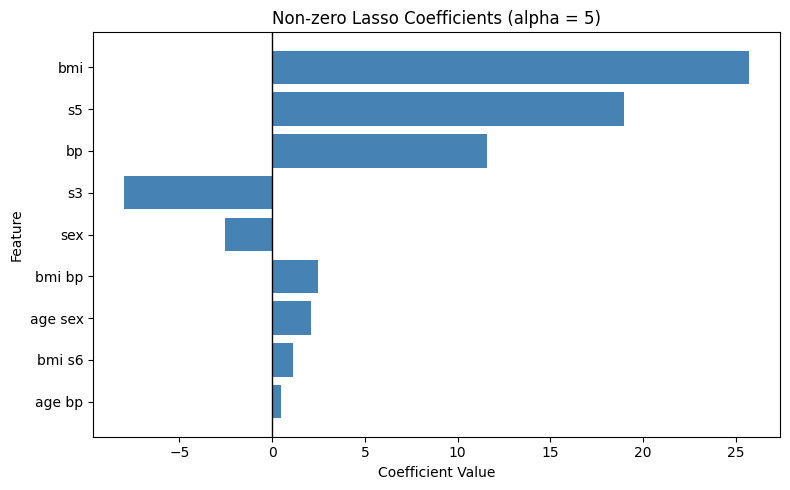

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
# Get feature names after polynomial expansion
feature_names = pf.get_feature_names_out(X_train.columns)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_poly_c.coef_
})

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

# Section 3. Conclusion

Given everything you have explored in this exercise (and what we discussed in the course) about **regularization, interaction terms, overfitting**, and **model generalizability**, what is your perspective on the **bias–variance trade-off** and the **interpretability trade-off** for this dataset?

Take a moment to reflect and collect your thoughts before revealing my answer below.

<details>
<summary>Click to reveal my answer</summary>

**Conclusion (my version)**

Across both experiments, **regularization consistently improves model performance**, confirming its role in **reducing variance** and **enhancing generalization**.

When we extend the feature space to include **interaction terms**, we observe a modest additional improvement in test-set R², indicating that these nonlinear interactions capture a small portion of residual structure that the purely linear model could not explain.

However, as seen from both the performance metrics and the most influential predictors identified by Lasso (α = 5), the qualitative story remains the same: the model’s insights and key drivers of diabetes progression are largely unchanged.

This suggests that, for this dataset, the relationships between predictors and the target are **predominantly linear and additive**, and the marginal gains from including polynomial interactions may not justify the added complexity or overfitting risk for future data.

In practice, this highlights an important modeling principle:

<u>**Regularization helps control variance, while model expansion helps reduce bias; but the goal is not maximum complexity, it’s meaningful simplicity**.<u>